In [199]:
from typing import Tuple, List, Dict
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import (alexnet,
                                AlexNet_Weights,
                                resnet18,
                                ResNet18_Weights,
                                ResNet,
                                resnet101)

from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np


In [200]:
class NeuralImageCompressor(nn.Module):
    def __init__(self,
                 encoder: nn.Module,
                 decoder: nn.Module,
                 normalising_activation: nn.Module = nn.Sigmoid(),
                 B: int = 1):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.normalising_activation = normalising_activation
        self.B = B
            
    def _get_quantization_error(self, shape: Tuple[int, ...]):
        mean = torch.full(shape, -0.5)
        std = torch.full(shape, 0.5)
        return 0.5**self.B * torch.normal(mean = mean, std = std)
    
    def forward(self, x):
        out = self.encoder(x)
        out = self.normalising_activation(out)
        out += self._get_quantization_error(out.shape)
        out = self.decoder(out)
        return out

In [201]:
class AutoencoderAlexNet(NeuralImageCompressor):
    def __init__(self, B: int = 1, normalising_activation: nn.Module = nn.Sigmoid()):
        encoder = alexnet(weights=AlexNet_Weights.DEFAULT).features
        decoder = self._get_decoder(encoder)
        super().__init__(encoder, decoder, normalising_activation, B)
    
    @staticmethod
    def _get_decoder(encoder: nn.Sequential):
        decoder_modules = []

        for module in reversed(encoder):
            if isinstance(module, nn.Conv2d):
                trans_conv = nn.ConvTranspose2d(
                    in_channels=module.out_channels,
                    out_channels=module.in_channels,
                    kernel_size=module.kernel_size,
                    stride=module.stride,
                    padding=module.padding
                )
                decoder_modules.append(trans_conv)
            elif isinstance(module, nn.ReLU):
                decoder_modules.append(nn.ReLU(inplace=True))
            elif isinstance(module, nn.MaxPool2d):
                # We can use MaxUnpool if we're going to save MaxPool indicies
                # unpool = nn.MaxUnpool2d(
                #     kernel_size=module.kernel_size,
                #     stride=module.stride,
                #     padding=module.padding
                # )
                upsample = nn.Upsample(
                    scale_factor=2,
                    mode='nearest'
                )
                decoder_modules.append(upsample)
            else:
                raise ValueError(f"unexpected module {module}")
            
        decoder = nn.Sequential(*decoder_modules)
        return decoder

In [202]:
alexnet_autoencoder = AutoencoderAlexNet()

test_image = torch.rand(3, 256, 256)

alexnet_autoencoder(test_image.unsqueeze(0)).shape

torch.Size([1, 3, 227, 227])

In [203]:
class AutoEncoderResNet(NeuralImageCompressor):
    def __init__(self, resnet: ResNet, decoder: nn.Module,
                 normalising_activation: nn.Module = nn.Sigmoid(), B: int = 1):
        encoder = self._get_resnet_encoder(resnet)
        super().__init__(encoder, decoder, normalising_activation, B)
    
    @staticmethod
    def _get_resnet_encoder(resnet: ResNet):
        return nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4)

In [204]:
def decoder_8x_upsample_constructor(in_chan_num):
    out_chan_nums = [512, 256, 128, 64, 3]

    decoder_modules = []

    for out_chan_num in out_chan_nums:
        decoder_modules.append(
            nn.Sequential(
                nn.Upsample(
                    scale_factor=2,
                    mode='nearest'
                ),
                nn.Conv2d(in_channels=in_chan_num, out_channels=out_chan_num, kernel_size=3, stride=1, padding=1),
                nn.ReLU()
            )
        )

        in_chan_num = out_chan_num
    
    return nn.Sequential(*decoder_modules)

In [205]:
def resnet_encoder_constructor(resnet):
    return nn.Sequential(
        resnet.conv1,
        resnet.bn1,
        resnet.relu,
        resnet.maxpool,
        resnet.layer1,
        resnet.layer2,
        resnet.layer3,
        resnet.layer4)

In [206]:
def create_resnet_autoencoder(resnet: ResNet, decoder_in_channels = 512):
    resnet_encoder = resnet_encoder_constructor(resnet)
    decoder_8x_upsample = decoder_8x_upsample_constructor(decoder_in_channels)
    resnet_autoencoder = NeuralImageCompressor(resnet_encoder, decoder_8x_upsample, nn.Sigmoid(), 1)
    return resnet_autoencoder


resnet_autoencoder = create_resnet_autoencoder(resnet18(weights=ResNet18_Weights.DEFAULT))

In [207]:
test_image = torch.rand(3, 64, 64)
resnet_autoencoder(test_image.unsqueeze(0)).shape

torch.Size([1, 3, 64, 64])

In [208]:
two_test_images = torch.rand(2, 3, 32, 32)
resnet_autoencoder(two_test_images).shape

torch.Size([2, 3, 32, 32])

In [209]:
# def get_output_channels_of_resnet_encoder(resnet_encoder):
#     num_out_channels = None
#     for module in reversed(resnet_encoder[-1][-1]):
#         if isinstance(module, nn.Conv2d):
#             last_conv = module
#             num_out_channels = module.out_channels
#     return num_out_channels

In [210]:
# list(resnet_encoder[-1][-1].children())

In [211]:
# Upsampling with transposed convolution

import torch
import torch.nn as nn

input_size = (3, 16, 16)  # Input tensor size (channels, height, width)
output_channels = 3  # Number of output channels
kernel_size = 4  # Kernel size in the transpose convolution
stride = 2  # Stride in the transpose convolution
padding = 1  # Padding in the transpose convolution

# Create a random input tensor
input_tensor = torch.randn(1, *input_size)

# Define the transpose convolution layer
trans_conv = nn.ConvTranspose2d(
    in_channels=input_size[0],
    out_channels=output_channels,
    kernel_size=kernel_size,
    stride=stride,
    padding=padding
)

# Apply the transpose convolution to the input tensor
output_tensor = trans_conv(input_tensor)

# Check the size of the output tensor
print("Input size:", input_tensor.size())
print("Output size:", output_tensor.size())

Input size: torch.Size([1, 3, 16, 16])
Output size: torch.Size([1, 3, 32, 32])


In [212]:
# datasets_path = "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC" 
# train_path = os.path.join(datasets_path, "train")
# transform = None
# train_dataset = ImageFolder(root=train_path,transform = transform)

In [213]:
import skimage.io
from PIL import Image 

class ImageFolderSelectedDirs(Dataset):
    def __init__(self, root, dirs=None, transform=None):
        self.root = root
        self.dirs = dirs
        self.transform = transform
        self.images = []
        self._set_images()
    
    def _set_images(self):
        for dir_name in self.dirs:
            dir_path = os.path.join(self.root, dir_name)
            for filename in os.listdir(dir_path):
                self.images.append(
                    os.path.join(
                        dir_path,
                        filename))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.get_image(idx)
        
        if self.transform:
            image = self.transform(image)
        return image
    
    def get_image(self, idx):
        image_path = self.images[idx]
        image = skimage.io.imread(image_path)
        
        if len(image.shape) == 2 or image.shape[2] ==1:
            image = self.convert_1ch_to_3ch(image)
            print(image.shape)
        image = Image.fromarray(image)
        return image
    
    @staticmethod
    def convert_1ch_to_3ch(image):
        return np.dstack([image, image, image])

In [214]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
imagenet_normalize = transforms.Normalize(imagenet_mean, imagenet_std)

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size = (256, 256), scale=(0.5, 1.0), ratio=(1.0, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        imagenet_normalize
    ]),
    'val': transforms.Compose([
        transforms.RandomResizedCrop(size = (256, 256), scale=(0.08, 1.0), ratio=(1., 1.)),
        transforms.ToTensor(),
        imagenet_normalize
    ]),
}

In [215]:
# datasets_root = "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC"
# dirs = dirname_to_classname.keys() 
# phases = ["train", "val"]

# dataset_paths = {phase: os.path.join(datasets_path, phase) for phase in phases}
# datasets = {phase: ImageFolderSelectedDirs(root = dataset_paths[phase], dirs = dirs, transform = data_transforms[phase]) for phase in phases}

In [216]:
dirname_to_classname = {
    "n02486410": "baboon",
    "n07720875": "bell pepper",
    "n03124170": "cowboy hat",
    "n02493509": "titi, titi monkey",
    "n02110627": "affenpinscher, monkey pinscher, monkey dog",
    "n02493793": "spider monkey, Ateles geoffroyi",
}

In [217]:
# for k in dirname_to_classname.keys():
#     print(f"{k} in class_indx = {k in class_idxs}")

class_idxs = os.listdir("/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train")
all(k in class_idxs for k in dirname_to_classname.keys())

True

In [218]:
datasets_root = "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC"
dirs = dirname_to_classname.keys() 
phases = ["train", "val"]

train_data_transform = data_transforms["train"]
train_dataset_path  = os.path.join(datasets_root, "train")
train_dataset = ImageFolderSelectedDirs(
    root = train_dataset_path,
    dirs = dirs,
    transform = train_data_transform)

In [219]:
len(train_dataset)

7454

In [220]:
train_dataset[3150]

tensor([[[-0.9534, -1.0048, -0.8164,  ..., -1.2103, -1.5014, -1.4672],
         [-1.0733, -1.0048, -0.8849,  ..., -1.1589, -1.2959, -1.3644],
         [-1.2445, -1.1589, -1.1760,  ..., -1.1932, -1.1932, -1.1760],
         ...,
         [-0.0458, -0.1143, -0.0972,  ..., -0.6623, -0.6794, -0.0801],
         [-0.1999, -0.2513, -0.2171,  ..., -0.6281, -0.6794, -0.2856],
         [-0.3198, -0.1314, -0.2171,  ..., -0.7308, -0.8164, -0.7822]],

        [[-1.1779, -1.1779, -1.0903,  ..., -1.3179, -1.5630, -1.4755],
         [-1.2479, -1.1954, -1.1429,  ..., -1.2829, -1.4230, -1.3004],
         [-1.2829, -1.2479, -1.1253,  ..., -1.1954, -1.3880, -1.1954],
         ...,
         [-0.1099, -0.1625, -0.1975,  ..., -0.7402, -0.7752, -0.5126],
         [-0.2150, -0.2675, -0.2675,  ..., -1.0028, -0.8627, -0.7227],
         [-0.3025, -0.3725, -0.3375,  ..., -1.3004, -1.1954, -1.0028]],

        [[-1.0201, -1.0027, -1.0027,  ..., -1.1073, -1.3164, -1.3513],
         [-1.1596, -1.1421, -1.1247,  ..., -1

In [221]:
type(train_dataset.get_image(3150))

PIL.Image.Image

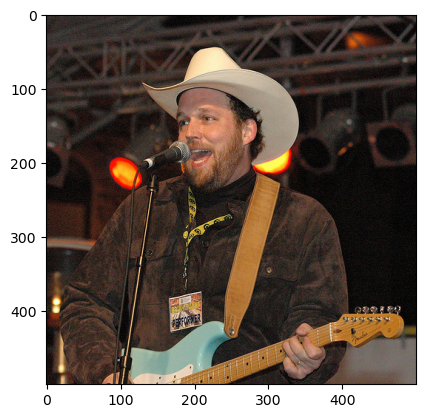

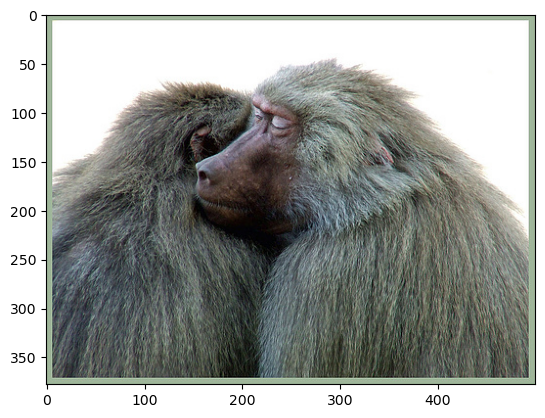

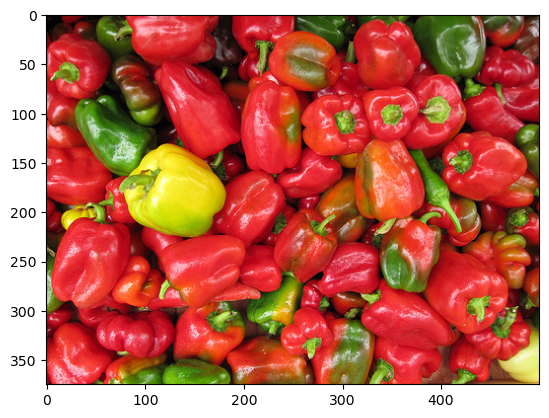

In [222]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset.get_image(3150))
plt.show()
plt.imshow(train_dataset.get_image(120))
plt.show()
plt.imshow(train_dataset.get_image(1390))
plt.show()

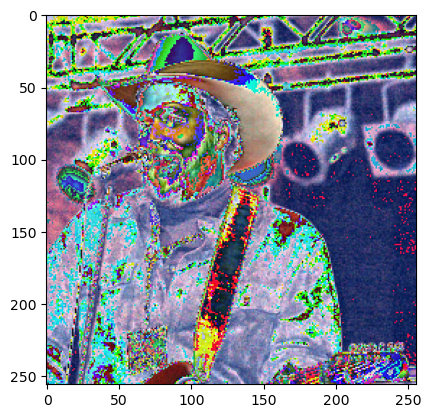

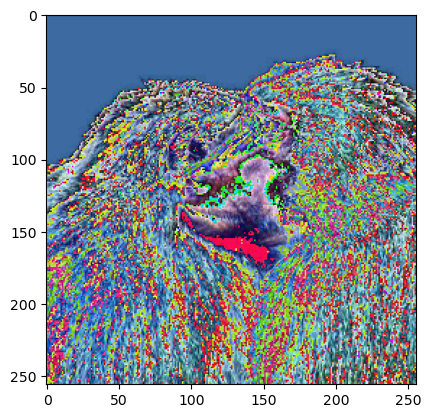

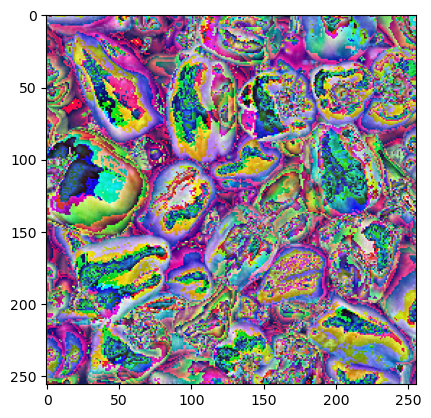

In [223]:
to_pil = transforms.functional.to_pil_image
    
import matplotlib.pyplot as plt
plt.imshow(to_pil(train_dataset[3150]))
plt.show()
plt.imshow(to_pil(train_dataset[120]))
plt.show()
plt.imshow(to_pil(train_dataset[1390]))
plt.show()

In [224]:
train_dataset[1].shape

torch.Size([3, 256, 256])

In [225]:
def train(model, optimizer, criterion,
          dataloaders: Dict[str, DataLoader], epochs,
          phases: List[str] = ["train", "val"]):
    for epoch in range(epochs):
        for phase in phases:
            if phase not in ["train", "val"]:
                raise ValueError('phases cannot contain a phase other than "train" or "val"')
            dataloaders[phase]
            
            pbar = tqdm(
                dataloaders[phase],
                total=len(dataloaders[phase]))
            
            for image in pbar:
                pass

In [226]:
dummy_datasets = {"train": train_dataset, "val": train_dataset}
dummy_dataloaders = {
    "train": DataLoader(train_dataset, batch_size = 16, shuffle = True),
    "val": DataLoader(train_dataset, batch_size = 16, shuffle = False)}

In [227]:
resnet_autoencoder = create_resnet_autoencoder(resnet18(weights=ResNet18_Weights.DEFAULT))
optimizer = torch.optim.Adam(resnet_autoencoder.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

epochs = 1

In [228]:
train(resnet_autoencoder, optimizer, criterion, dummy_dataloaders, epochs, phases = ["train"])

  3%|▎         | 13/466 [00:02<01:10,  6.42it/s]

(500, 375, 3)
(231, 176, 3)


  4%|▎         | 17/466 [00:02<01:07,  6.70it/s]

(500, 484, 3)


  4%|▍         | 19/466 [00:03<01:07,  6.61it/s]

(434, 500, 3)


  6%|▌         | 29/466 [00:04<01:13,  5.98it/s]

(326, 500, 3)


 11%|█         | 50/466 [00:08<01:04,  6.43it/s]

(512, 512, 3)
(500, 357, 3)


 13%|█▎        | 62/466 [00:10<01:12,  5.61it/s]

(74, 74, 3)


 14%|█▍        | 66/466 [00:11<01:05,  6.10it/s]

(500, 375, 3)


 15%|█▌        | 71/466 [00:12<01:03,  6.26it/s]

(473, 515, 3)


 18%|█▊        | 82/466 [00:14<01:07,  5.72it/s]

(500, 332, 3)
(348, 500, 3)


 18%|█▊        | 85/466 [00:14<00:59,  6.36it/s]

(500, 342, 3)


 19%|█▊        | 87/466 [00:14<00:59,  6.37it/s]

(334, 500, 3)


 22%|██▏       | 104/466 [00:17<01:05,  5.52it/s]

(500, 375, 3)


 23%|██▎       | 108/466 [00:18<00:56,  6.37it/s]

(500, 375, 3)


 24%|██▍       | 113/466 [00:19<00:58,  6.00it/s]

(500, 333, 3)


 27%|██▋       | 126/466 [00:21<00:55,  6.09it/s]

(50, 50, 3)
(465, 400, 3)


 30%|███       | 140/466 [00:23<00:51,  6.35it/s]

(333, 500, 3)


 32%|███▏      | 149/466 [00:25<00:49,  6.42it/s]

(500, 395, 3)


 32%|███▏      | 151/466 [00:25<00:49,  6.40it/s]

(375, 500, 3)


 33%|███▎      | 155/466 [00:25<00:47,  6.54it/s]

(500, 333, 3)


 34%|███▎      | 157/466 [00:26<00:49,  6.26it/s]

(375, 500, 3)
(335, 500, 3)


 34%|███▍      | 159/466 [00:26<00:51,  6.01it/s]

(500, 442, 3)


 35%|███▌      | 165/466 [00:27<00:51,  5.89it/s]

(343, 500, 3)


 37%|███▋      | 172/466 [00:28<00:48,  6.08it/s]

(500, 375, 3)


 39%|███▉      | 181/466 [00:30<00:45,  6.31it/s]

(500, 378, 3)


 39%|███▉      | 182/466 [00:30<00:45,  6.29it/s]

(500, 406, 3)


 42%|████▏     | 194/466 [00:32<00:46,  5.86it/s]

(354, 500, 3)


 42%|████▏     | 197/466 [00:33<00:43,  6.23it/s]

(390, 451, 3)
(375, 500, 3)
(920, 660, 3)


 46%|████▌     | 215/466 [00:36<00:40,  6.23it/s]

(333, 500, 3)


 47%|████▋     | 220/466 [00:36<00:40,  6.03it/s]

(420, 500, 3)


 50%|████▉     | 231/466 [00:38<00:42,  5.57it/s]

(205, 184, 3)
(121, 216, 3)


 52%|█████▏    | 240/466 [00:40<00:42,  5.34it/s]

(40, 37, 3)


 53%|█████▎    | 245/466 [00:41<00:41,  5.35it/s]

(333, 500, 3)


 54%|█████▍    | 251/466 [00:42<00:37,  5.73it/s]

(374, 500, 3)


 57%|█████▋    | 267/466 [00:45<00:34,  5.73it/s]

(500, 500, 3)


 59%|█████▊    | 273/466 [00:46<00:31,  6.18it/s]

(500, 331, 3)


 60%|██████    | 280/466 [00:47<00:29,  6.30it/s]

(500, 389, 3)


 61%|██████▏   | 286/466 [00:48<00:28,  6.31it/s]

(500, 478, 3)


 63%|██████▎   | 293/466 [00:49<00:32,  5.36it/s]

(500, 377, 3)


 63%|██████▎   | 294/466 [00:49<00:31,  5.42it/s]

(500, 375, 3)
(539, 370, 3)


 65%|██████▌   | 305/466 [00:51<00:24,  6.48it/s]

(250, 500, 3)


 67%|██████▋   | 313/466 [00:53<00:26,  5.84it/s]

(500, 333, 3)


 68%|██████▊   | 318/466 [00:53<00:24,  6.14it/s]

(250, 151, 3)


 71%|███████   | 330/466 [00:55<00:20,  6.60it/s]

(470, 500, 3)


 72%|███████▏  | 334/466 [00:56<00:20,  6.40it/s]

(324, 400, 3)


 74%|███████▍  | 344/466 [00:58<00:18,  6.56it/s]

(500, 330, 3)


 74%|███████▍  | 347/466 [00:58<00:19,  6.17it/s]

(500, 335, 3)


 75%|███████▌  | 350/466 [00:58<00:18,  6.22it/s]

(500, 357, 3)


 76%|███████▋  | 356/466 [00:59<00:17,  6.33it/s]

(500, 355, 3)


 78%|███████▊  | 362/466 [01:01<00:17,  5.95it/s]

(333, 500, 3)


 79%|███████▊  | 366/466 [01:01<00:17,  5.74it/s]

(500, 333, 3)


 79%|███████▉  | 369/466 [01:02<00:16,  6.02it/s]

(500, 338, 3)


 79%|███████▉  | 370/466 [01:02<00:16,  5.89it/s]

(500, 445, 3)


 80%|████████  | 375/466 [01:03<00:14,  6.25it/s]

(500, 355, 3)
(398, 500, 3)


 81%|████████▏ | 379/466 [01:03<00:13,  6.30it/s]

(500, 355, 3)
(375, 500, 3)


 85%|████████▌ | 397/466 [01:06<00:10,  6.29it/s]

(375, 500, 3)


 86%|████████▌ | 399/466 [01:07<00:10,  6.35it/s]

(500, 333, 3)


 86%|████████▋ | 402/466 [01:07<00:10,  6.16it/s]

(500, 500, 3)
(375, 500, 3)


 88%|████████▊ | 408/466 [01:08<00:09,  6.09it/s]

(333, 500, 3)
(500, 499, 3)
(238, 275, 3)


 90%|████████▉ | 419/466 [01:10<00:08,  5.77it/s]

(487, 500, 3)


 91%|█████████ | 425/466 [01:11<00:07,  5.64it/s]

(500, 354, 3)
(375, 500, 3)


 91%|█████████▏| 426/466 [01:11<00:06,  5.75it/s]

(448, 500, 3)
(423, 500, 3)
(381, 400, 3)


 96%|█████████▌| 448/466 [01:15<00:02,  6.22it/s]

(494, 500, 3)


 98%|█████████▊| 455/466 [01:16<00:02,  5.42it/s]

(500, 463, 3)


100%|█████████▉| 465/466 [01:18<00:00,  5.11it/s]/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:646: UserWarning: Metadata Warning, tag 33723 had too many entries: 11, expected 1
  warnings.warn(
100%|██████████| 466/466 [01:18<00:00,  5.90it/s]


In [198]:
train_dataset_without_transform = ImageFolderSelectedDirs(
    root = train_dataset_path,
    dirs = dirs,
    transform = transforms.ToTensor())

In [138]:
train_dataset_shape_lens = set()
for i, img in enumerate(train_dataset_without_transform):
    train_dataset_shape_lens.add(len(img.shape))

train_dataset_shape_lens

ValueError: not enough values to unpack (expected 3, got 2)

In [156]:
chan_nums = set()
for i, img in tqdm(enumerate(train_dataset_without_transform), total = len(train_dataset_without_transform)):
    chan_nums.add(img.shape[0])

chan_nums

  7%|▋         | 523/7454 [00:04<00:54, 127.29it/s]


ValueError: not enough values to unpack (expected 3, got 2)

In [139]:
type(train_dataset)

__main__.ImageFolderSelectedDirs

In [75]:
chan_nums

{3}